<center>
    <h1> INF477 - Redes Neuronales Artificiales  </h1>
    <h2> Tarea #2 - Parte I: Entrenamiento de Autoencoders (AEs) y RBMs en MNIST </h2> 
</center>

Tarea realizada por:
* Alvaro Salinas - `alvaro.salinase@gmail.com` - **rol:** 201073001-8
* Martín Villanueva - `martin.villanueva@alumnos.usm.cl` - **rol:** 201104012-0

_DI UTFSM. Septiembre 2016._

## Tabla de Contenidos
* [1.0 Helper](#helper)
    * [Parte (a)](#1.0a)
* [1.1 Reducción de dimensionalidad](#dim)
    * [Parte (a)](#1.1a)
    * [Parte (b)](#1.1b)
    * [Parte (c)](#1.1c)
    * [Parte (d)](#1.1d)
    * [Parte (e)](#1.1e)
    * [Parte (f)](#1.1f)
    * [Parte (g)](#1.1g)
    * [Parte (h)](#1.1h)
    * [Parte (i)](#1.1i)
    * [Parte (j)](#1.1j)
* [1.2 Denoising](#den)
    * [Parte (a)](#1.2a)
    * [Parte (b)](#1.2b)
    * [Parte (c)](#1.2c)
    * [Parte (d)](#1.2d)
    * [Parte (e)](#1.2e)
    * [Parte (f)](#1.2f)
    * [Parte (g)](#1.2g)
* [1.3 Pre-entrenamiento](#pretr)
    * [Parte (a)](#1.3a)
    * [Parte (b)](#1.3b)
    * [Parte (c)](#1.3c)
    * [Parte (d)](#1.3d)
    * [Parte (e)](#1.3e)
    * [Parte (f)](#1.3f)
    * [Parte (g)](#1.3g)
    * [Parte (h)](#1.3h)

In [20]:
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.optimizers import SGD
from keras.objectives import binary_crossentropy

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.neural_network import BernoulliRBM

<div id='helper'/>
## 1.0 - Helper

<div id='1.0a'/>
### Parte (a)

In [4]:
def load_helper(nval=1000):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    # 0-1 scaling
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    # reshaping
    X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
    X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
    # training / validation split
    X_val = X_train[-nval:]
    y_val = y_train[-nval:]
    X_train = X_train[:-nval]
    y_train = y_train[:-nval]
    # correct format
    y_train = np_utils.to_categorical(y_train, 10)
    y_val = np_utils.to_categorical(y_val, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    return X_train, X_val, X_test, y_train, y_val, y_test    

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = load_helper()

<div id='dim'/>
## 1.1 - Reducción de Dimensionalidad

### Parte (a)

In [6]:
def train_basic_ae(X_train, X_val, hidden_size=32, activation1='sigmoid', activation2='sigmoid'):
    input_img = Input(shape=(784,))
    encoded = Dense(hidden_size, activation=activation1)(input_img)
    decoded = Dense(784, activation=activation2)(encoded)
    # building encoder, decoder and autoencoder
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(hidden_size,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(X_train, X_train, nb_epoch=50, batch_size=25, shuffle=True, 
                    validation_data=(X_val, X_val), verbose=0)
    # saving results
    encoder.save('enc_{0}d_{1}.h5'.format(hidden_size, activation1))
    decoder.save('dec_{0}d_{1}.h5'.format(hidden_size, activation1))
    autoencoder.save('ae_{0}d_{1}.h5'.format(hidden_size, activation1))
    return encoder, decoder, autoencoder

#### Función de activación: `Sigmoidal` (En `encoder` y `decoder`)

In [9]:
[enc_2d_sigmoid, dec_2d_sigmoid, ae_2d_sigmoid] = train_basic_ae(X_train, X_val, hidden_size=2)
print('Porcentaje de compresion: {0}%'.format(2./784 * 100))
rec_err = ae_2d_sigmoid.evaluate(X_test, ae_2d_sigmoid.predict(X_test), verbose=0)
print('Error de reconstruccion: {0}'.format(rec_err))

Porcentaje de compresion: 0.255102040816%
Error de reconstruccion: 0.267708333111


In [10]:
[enc_8d_sigmoid, dec_8d_sigmoid, ae_8d_sigmoid] = train_basic_ae(X_train, X_val, hidden_size=8)
print('Porcentaje de compresion: {0}%'.format(8./784 * 100))
rec_err = ae_8d_sigmoid.evaluate(X_test, ae_8d_sigmoid.predict(X_test), verbose=0)
print('Error de reconstruccion: {0}'.format(rec_err))

Porcentaje de compresion: 1.02040816327%
Error de reconstruccion: 0.264048975945


In [11]:
[enc_32d_sigmoid, dec_32d_sigmoid, ae_32d_sigmoid] = train_basic_ae(X_train, X_val, hidden_size=32)
print('Porcentaje de compresion: {0}%'.format(32./784 * 100))
rec_err = ae_32d_sigmoid.evaluate(X_test, ae_32d_sigmoid.predict(X_test), verbose=0)
print('Error de reconstruccion: {0}'.format(rec_err))

Porcentaje de compresion: 4.08163265306%
Error de reconstruccion: 0.203979788995


In [12]:
[enc_64d_sigmoid, dec_64d_sigmoid, ae_64d_sigmoid] = train_basic_ae(X_train, X_val, hidden_size=64)
print('Porcentaje de compresion: {0}%'.format(64./784 * 100))
rec_err = ae_64d_sigmoid.evaluate(X_test, ae_64d_sigmoid.predict(X_test), verbose=0)
print('Error de reconstruccion: {0}'.format(rec_err))

Porcentaje de compresion: 8.16326530612%
Error de reconstruccion: 0.161245168853


#### Función de activación: `ReLU` (en `encoder`) y `Sigmoidal` (en `decoder`) 

In [13]:
[enc_2d_relu, dec_2d_relu, ae_2d_relu] = train_basic_ae(X_train, X_val, hidden_size=2, activation1='relu')
print('Porcentaje de compresion: {0}%'.format(2./784 * 100))
rec_err = ae_2d_relu.evaluate(X_test, ae_2d_relu.predict(X_test), verbose=0)
print('Error de reconstruccion: {0}'.format(rec_err))

Porcentaje de compresion: 0.255102040816%
Error de reconstruccion: 0.23255332377


In [14]:
[enc_8d_relu, dec_8d_relu, ae_8d_relu] = train_basic_ae(X_train, X_val, hidden_size=8, activation1='relu')
print('Porcentaje de compresion: {0}%'.format(8./784 * 100))
rec_err = ae_8d_relu.evaluate(X_test, ae_8d_relu.predict(X_test), verbose=0)
print('Error de reconstruccion: {0}'.format(rec_err))

Porcentaje de compresion: 1.02040816327%
Error de reconstruccion: 0.168912522221


In [15]:
[enc_32d_relu, dec_32d_relu, ae_32d_relu] = train_basic_ae(X_train, X_val, hidden_size=32, activation1='relu')
print('Porcentaje de compresion: {0}%'.format(32./784 * 100))
rec_err = ae_32d_relu.evaluate(X_test, ae_32d_relu.predict(X_test), verbose=0)
print('Error de reconstruccion: {0}'.format(rec_err))

Porcentaje de compresion: 4.08163265306%
Error de reconstruccion: 0.0932039486647


In [16]:
[enc_64d_relu, dec_64d_relu, ae_64d_relu] = train_basic_ae(X_train, X_val, hidden_size=64, activation1='relu')
print('Porcentaje de compresion: {0}%'.format(64./784 * 100))
rec_err = ae_64d_relu.evaluate(X_test, ae_64d_relu.predict(X_test), verbose=0)
print('Error de reconstruccion: {0}'.format(rec_err))

Porcentaje de compresion: 8.16326530612%
Error de reconstruccion: 0.0737657311678


**Nota:** No es posible ocupar en este caso una función de activación `ReLU` para el `decoder`, dado que esto da la posibilidad de obtener valores $\geq 1$ (Lo cual no es posible, pues la representación se definió de tal modo que los valores están en $[0,1]$).

### Parte (b)

In [37]:
def visualize_reconstruction(X_test, ae):
    decoded_test = ae.predict(X_test)
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

#### Encoder con `sigmoid` y `d=8`

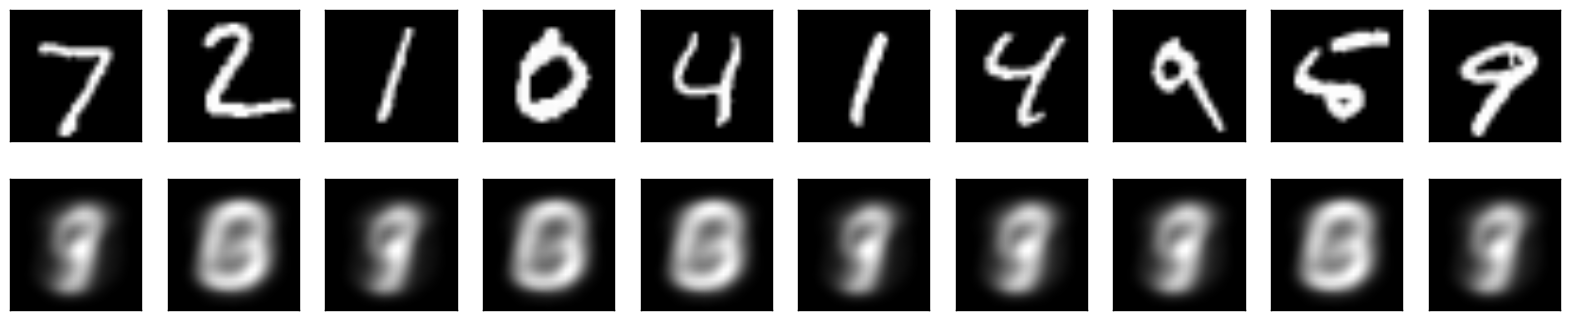

In [39]:
visualize_reconstruction(X_test, ae_8d_sigmoid)

#### Encoder con `sigmoid` y `d=64` 

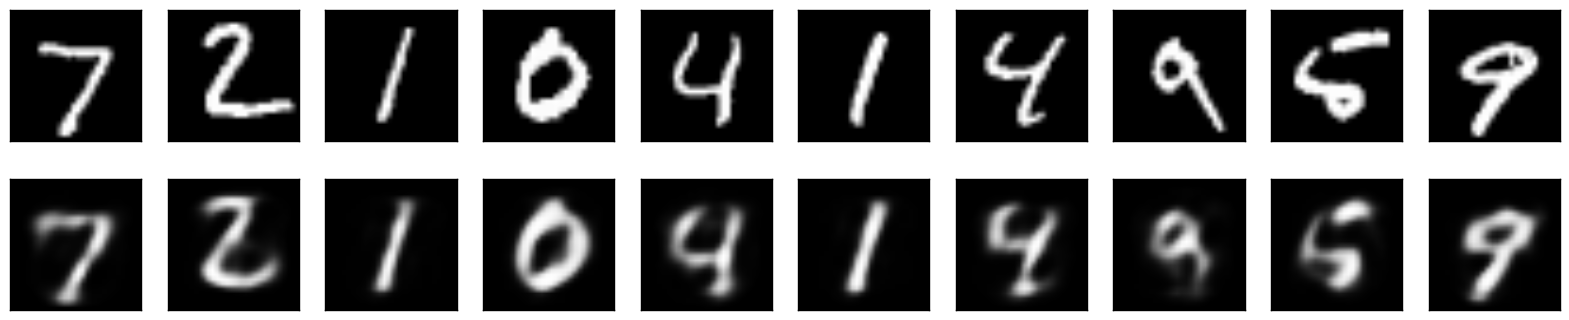

In [40]:
visualize_reconstruction(X_test, ae_64d_sigmoid)

#### Encoder con `relu` y `d=8`

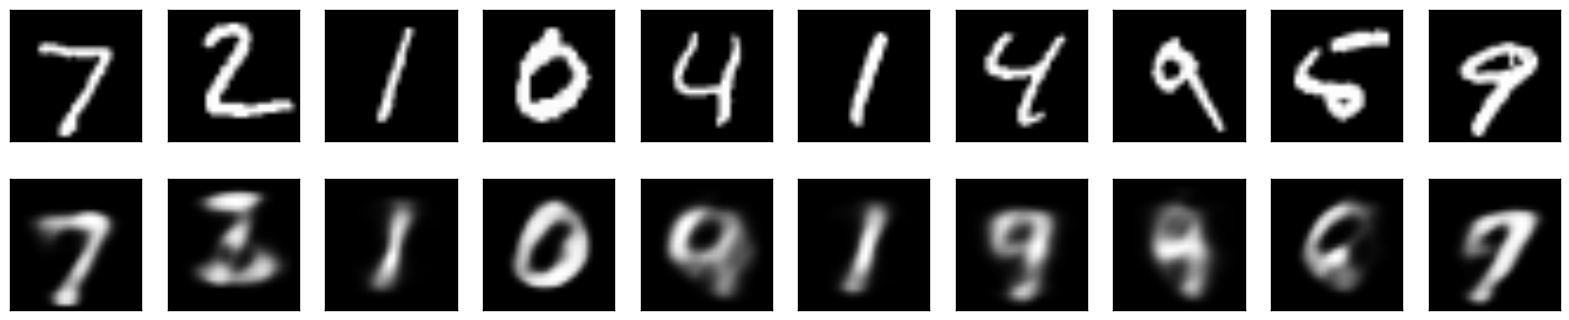

In [41]:
visualize_reconstruction(X_test, ae_8d_relu)

#### Encoder con `relu` y `d=64`

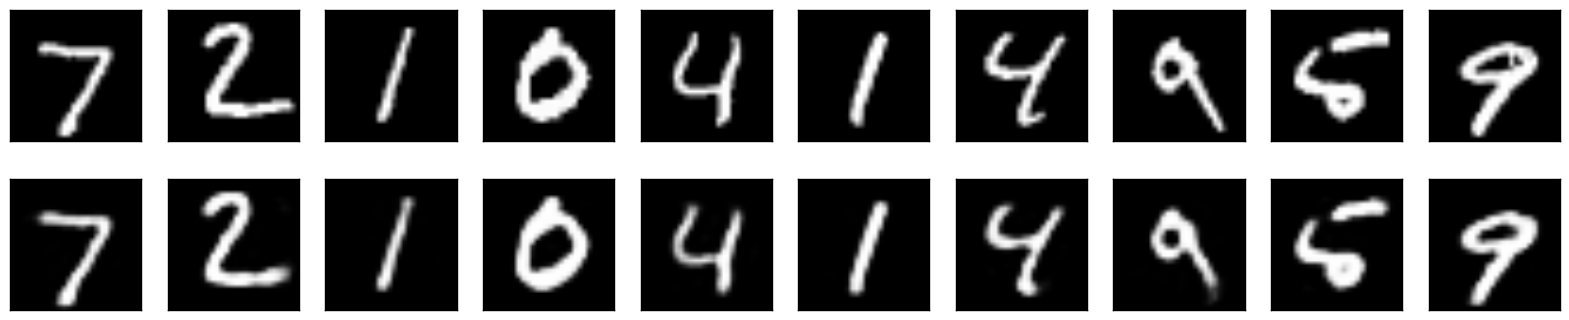

In [42]:
visualize_reconstruction(X_test, ae_64d_relu)

### Parte (c)

In [23]:
def knn_classification_accuracy(X_train, y_train, X_test, y_test):
    clf = KNeighborsClassifier(10)
    t0 = time.time()
    clf.fit(X_train, y_train)
    elapsed = time.time()-t0
    score = clf.score(X_test, y_test)
    print('Classification Accuracy: %.2f' % score)
    print('Elapsed time: {0}[s] \n'.format(elapsed))

In [25]:
print('Sigmoid + d=2')
knn_classification_accuracy(enc_2d_sigmoid.predict(X_train), y_train, enc_2d_sigmoid.predict(X_test), y_test)

print('Sigmoid + d=8')
knn_classification_accuracy(enc_8d_sigmoid.predict(X_train), y_train, enc_8d_sigmoid.predict(X_test), y_test)

print('Sigmoid + d=32')
knn_classification_accuracy(enc_32d_sigmoid.predict(X_train), y_train, enc_32d_sigmoid.predict(X_test), y_test)

print('Sigmoid + d=64')
knn_classification_accuracy(enc_64d_sigmoid.predict(X_train), y_train, enc_64d_sigmoid.predict(X_test), y_test)

print('ReLU + d=2')
knn_classification_accuracy(enc_2d_relu.predict(X_train), y_train, enc_2d_relu.predict(X_test), y_test)

print('ReLU + d=8')
knn_classification_accuracy(enc_8d_relu.predict(X_train), y_train, enc_8d_relu.predict(X_test), y_test)

print('ReLU + d=32')
knn_classification_accuracy(enc_32d_relu.predict(X_train), y_train, enc_32d_relu.predict(X_test), y_test)

print('ReLU + d=64')
knn_classification_accuracy(enc_64d_relu.predict(X_train), y_train, enc_64d_relu.predict(X_test), y_test)

print('Original data (No reduction)')
knn_classification_accuracy(X_train, y_train, X_test, y_test)

Sigmoid + d=2
Classification Accuracy: 0.00
Elapsed time: 0.448776960373[s] 

Sigmoid + d=8
Classification Accuracy: 0.18
Elapsed time: 0.112163066864[s] 

Sigmoid + d=32
Classification Accuracy: 0.83
Elapsed time: 0.181217908859[s] 

Sigmoid + d=64
Classification Accuracy: 0.95
Elapsed time: 0.304636001587[s] 

ReLU + d=2
Classification Accuracy: 0.22
Elapsed time: 0.0647070407867[s] 

ReLU + d=8
Classification Accuracy: 0.86
Elapsed time: 0.0793220996857[s] 

ReLU + d=32
Classification Accuracy: 0.96
Elapsed time: 0.166414022446[s] 

ReLU + d=64
Classification Accuracy: 0.95
Elapsed time: 0.311235189438[s] 

Original data (No reduction)
Classification Accuracy: 0.96
Elapsed time: 18.7843770981[s] 



### Parte (d)

In [41]:
def clustering_accuracy(y, pred_labels, nclusters=10):
    true_pred = 0.0
    for i in range(0, nclusters):
        mvlabel = np.argmax(np.bincount(y[pred_labels==i]))
        true_pred += sum(y[pred_labels==i] == mvlabel)
    return true_pred/len(y)

def clustering_scores(X_train, y_train):
    y_train = np.argmax(y_train, axis=1)
    model = KMeans(n_clusters=10)
    labels_pred = model.fit_predict(X_train)
    print('Clustering ARI: {0}'.format(adjusted_rand_score(y_train, labels_pred)))
    print('Clustering ACC: {0} \n'.format(clustering_accuracy(y_train, labels_pred)))

In [42]:
print('Sigmoid + d=2')
clustering_scores(enc_2d_sigmoid.predict(X_train), y_train)

print('Sigmoid + d=8')
clustering_scores(enc_8d_sigmoid.predict(X_train), y_train)

print('Sigmoid + d=32')
clustering_scores(enc_32d_sigmoid.predict(X_train), y_train)

print('Sigmoid + d=64')
clustering_scores(enc_64d_sigmoid.predict(X_train), y_train)

print('ReLU + d=2')
clustering_scores(enc_2d_relu.predict(X_train), y_train)

print('ReLU + d=8')
clustering_scores(enc_8d_relu.predict(X_train), y_train)

print('ReLU + d=32')
clustering_scores(enc_32d_relu.predict(X_train), y_train)

print('ReLU + d=64')
clustering_scores(enc_64d_relu.predict(X_train), y_train)

print('Original data (No reduction)')
clustering_scores(X_train, y_train)

Sigmoid + d=2
Clustering ARI: 0.000272498252964
Clustering ACC: 0.119983050847 

Sigmoid + d=8
Clustering ARI: 0.000800324299906
Clustering ACC: 0.11813559322 

Sigmoid + d=32
Clustering ARI: 0.353451509837
Clustering ACC: 0.574966101695 

Sigmoid + d=64
Clustering ARI: 0.410933774352
Clustering ACC: 0.610050847458 

ReLU + d=2
Clustering ARI: 0.177531118763
Clustering ACC: 0.375813559322 

ReLU + d=8
Clustering ARI: 0.301972563823
Clustering ACC: 0.507186440678 

ReLU + d=32
Clustering ARI: 0.223556527212
Clustering ACC: 0.476542372881 

ReLU + d=64
Clustering ARI: 0.238850809743
Clustering ACC: 0.437288135593 

Original data (No reduction)
Clustering ARI: 0.360236626723
Clustering ACC: 0.590508474576 



### Parte (e)

In [ ]:
def pca_reduction()

In [ ]:
pca = PCA(n_components=32)
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)
clf = KNeighborsClassifier(10)
clf.fit(pca_train, y_train)
score = clf.score(pca_test,y_test)
print 'PCA SCORE %.2f' % score

### Parte (f)

In [ ]:
model = BernoulliRBM(n_components=32, batch_size=25, learning_rate=0.05,verbose=1, n_iter=50) ##n_components is d'
model.fit(X_train) ##Train using persistent Gibbs chains
fileo = open('basicRBM.pickle','wb')
pickle.dump(model,fileo)
fileo.close()

### Parte (g)

In [57]:
s = '1000 500 250 2'
s.strip().split()

['1000', '500', '250', '2']

In [56]:
l

['1', '0', '0', '0', ' ', '5', '0', '0', ' ', '2', '5', '0', ' ', '2']

In [53]:
for size in l[-1::-1]: print size

2
250
500


In [54]:
def train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 2], activation='relu'):
    layers_list = []
    layers_list.append( Input(shape=(784,)) )
    # encoding model
    for size in layer_sizes[:-1]:
        layers_list.append( Dense(size, activation=activation)(layers_list[-1]) )
    encoded = layers_list[-1]
    # decoding model
    for size in layer_sizes[-1::-1]:
        layers_list.append( Dense(size, activation=activation)(layers_list[-1]) )
    layers_list.append( Dense(784, activation='sigmoid')(layers_list[-1]) )
    # encoder and autoencoder model
    encoder = Model(input=layers_list[0], output=encoded)
    autoencoder = Model(input=layers_list[0], output=layers_list[-1])
    # training step
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(X_train, X_train, nb_epoch=50, batch_size=25, shuffle=True, validation_data=(X_val, X_val))
    # saving results
    encoder.save('enc_{0}L_{1}d.h5'.format(len(layer_sizes), layer_sizes[-1]))
    autoencoder.save('ae_{0}L_{1}d.h5'.format(len(layer_sizes), layer_sizes[-1]))
    return autoencoder

#### `Layer size: 2`

In [ ]:
### ADVERTENCIA: La ejecucion de esta celda toma una cantidad considerable de tiempo
ae_2L_2d = train_deep_ae(X_train, X_val, layer_sizes=[250, 2])
ae_2L_4d = train_deep_ae(X_train, X_val, layer_sizes=[250, 4])
ae_2L_8d = train_deep_ae(X_train, X_val, layer_sizes=[250, 8])
ae_2L_16d = train_deep_ae(X_train, X_val, layer_sizes=[250, 16])
ae_2L_32d = train_deep_ae(X_train, X_val, layer_sizes=[250, 32])

#### `Layer size: 3`

In [ ]:
### ADVERTENCIA: La ejecucion de esta celda toma una cantidad considerable de tiempo
ae_3L_2d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 2])
ae_3L_4d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 4])
ae_3L_8d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 8])
ae_3L_16d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 16])
ae_3L_32d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 32])

#### `Layer size: 4`

In [ ]:
### ADVERTENCIA: La ejecucion de esta celda toma una cantidad considerable de tiempo
ae_4L_2d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 2])
ae_4L_4d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 4])
ae_4L_8d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 8])
ae_4L_16d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 16])
ae_4L_32d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 32])

### Parte (h)

### Parte (i)

### Parte (j)

<div id='den'/>
## 1.2 - Denoising

<div id='pretr'/>
## 1.3 - Pre-entrenamiento